# Introduction to control theory. 

## TP4. Full State Linear Feedback Controller.
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP4.ipynb)    

The completed notebooks should be sent to your tutor (elena.vanneaux@ensta.fr or adnan.saood@ensta.fr) before the beginning of the next session. Please add [APM_4AUT2_TA] to the topic of e-mail.

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html


## EX. 1: Inverted Pendulum

The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the attitude control of a booster rocket at takeoff.


Let us consider the system with the following system parameters
    
    (M)       mass of the cart                         0.5 kg
    
    (m)       mass of the pendulum                     0.2 kg
    
    (l)       length to pendulum center of mass        0.3 m
    
    (b)       coefficient of friction for cart         0.1 N/m/sec
    
    (I)       mass moment of inertia of the pendulum   0.006 kg.m^2
    
    (F)       force applied to the cart
    
    (y)       cart position coordinate
    
    (theta)   angle between the pendulum and the vertical axis

The Inverted pendulum on the cart can be modeled as follows

$$(M+m)\ddot{y} + b\dot{y} + ml\ddot{\theta}\cos\theta -ml\dot\theta^2\sin(\theta) = F$$

$$ml\cos(\theta)\ddot{y} + (I+ml^2)\ddot{\theta} - mgl\sin\theta = 0$$    

Let $y_1 = \dot{y}$ and $\theta_1 = \dot{\theta}$

The linearalised model have the following form

$$\dot x = Ax + B(u+w)$$

where state vector $x = (y,y_1,\theta,\theta_1)$, control vector $u$, disturbance $w$, and $F = u+w$. 

$$\left[\begin{array}{c}\dot{y} \\ \dot{y1} \\ \dot{\theta} \\ \dot{\theta_1}\end{array}\right]=
\left[\begin{array}{cccc}0 & 1 & 0 & 0 \\
0 & \frac{-\left(I+m l^2\right) b}{I(M+m)+M m l^2}& \frac{-g m^2 l^2}{I(M+m)+M m l^2} & 0 \\
0 & 0 & 0 & 1 \\
0 & \frac{m l b}{I(M+m)+M m l^2} & \frac{m g l(M+m)}{I(M+m)+M m l^2} & 0\end{array}\right]
\left[\begin{array}{c}y \\ y_1\\ \theta \\ \theta_1\end{array}\right]+
\left[\begin{array}{c}0 \\ \frac{I+m l^2}{I(M+m)+M m l^2} \\ 0\\ \frac{-m l}{I(M+m)+M m l^2}\end{array}\right] (u+w)$$

## TODO

1) Check on the code below implementing a PID controller ensuring tracking to the reference signal $\theta_{ref}$ = 0 rad, while supposing that the system is subject to a constant disturbance $w(t) = 0.1$. Is it a good controller for achieving the desirable behavior of the system?

This controller is not good because the angle and position are not stable and they grow to infinity.

2) Design a full-state linear feedback regulator u = -Kx that stabilize non distubed ($w(t) = 0$) system in (0,0,0,0).

    2.1 Is the system controllable? Why is it important? : This system is controllable. It is important to stabilize the system if a perturbation is applied.


    2.2 Use control.place function from control library https://python-control.readthedocs.io/en/0.9.4/ to place eigenvalues lam_1 = -1, lam_2 = -2, lam_3 = -3, lam_4 = -4 in the closed-loop system. I.e. find a K, such that eig(A-BK) = [-1,-2,-3,-4]. Let $x_0 = (1,0,1,0)$ plot the corresponding trajectories of the closed-loop system. Is the system controlled by the regulator u =-Kx stable?

    2.3 Use the LQR regulator to stabilize the system around zero. Plot the trajectory of controlled system starting from $x_0 = (1,0,1,0).$ Analyze how the different choice of weight matrices Q and R affects the closed-loop system behavior. control.lqr from the control library https://python-control.readthedocs.io/en/0.9.4/ might be useful for you.
3)Analyse the response of the system controlled with an LQR regulator for different types of disturbances (like $w(t) = 0.1, w(t) = 10.0, w(t) = sin(t)$ etc...). What conclusion can you make?    

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import control as ctr

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T) 

def PID(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0):
    z0 = np.array([[0.0]])
    x_a =  np.block([[x0.reshape(-1,1)],[z0]])
    M = np.eye(x0.shape[0]) + Kd*B @ C
    A_a = np.block([[np.linalg.inv(M) @ (A - Kp * B @ C), -Ki * np.linalg.inv(M) @ B ], [C, np.array([0.0])]])
    B_a =  np.block([[Kp * np.linalg.inv(M) @ B ], [np.array([1.0])]])
    D_a = np.block([[np.linalg.inv(M) @ D],[np.array([[0.0]])]])
    C_a = np.block([C, np.array([[0.0]])])
    return OpenLoopInputOutputSystem(A_a, B_a, D_a, C_a, r_func, w_func, T, x_a.flatten()).T    

Text(0, 0.5, 'Position ')

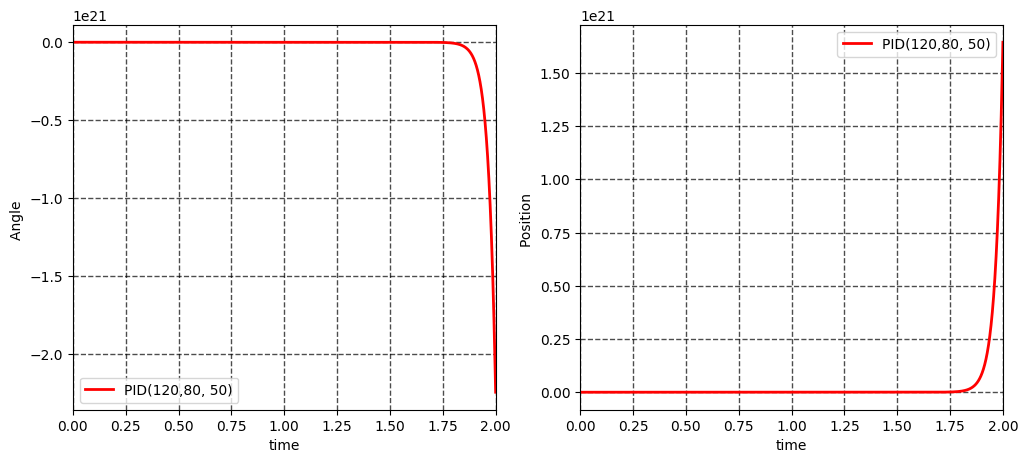

In [3]:
import sympy as sp
from matplotlib.pyplot import *
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = B

x0 = np.array([0,
               0,
               0,
               0])  # initial state

MatC = np.array([[0,0,1,0]]) # Let us assume that we measure only theta

Kp= 120;
Ki = 80;
Kd = 50;

t0 = 0 # Initial time 
tf = 2 # Final time
T = np.linspace(t0, tf, 1000) 

def w_func(t):
       return 0.1# Disturbance input

def r_func(t):
       return 0.0# Disturbance input


solution = PID(A, B, D, MatC , Kp, Ki, Kd, r_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[:,2]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[:,0]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

## Questions 2.2 and 2.3

We recreate the previous functions to have a u_func that is a function on both the time and position.

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import control as ctr

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(x,t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T)   

We first try to simply place the eigenvalues from -1 to -4 to get the K matrix (q.2.2).

Text(0, 0.5, 'Position ')

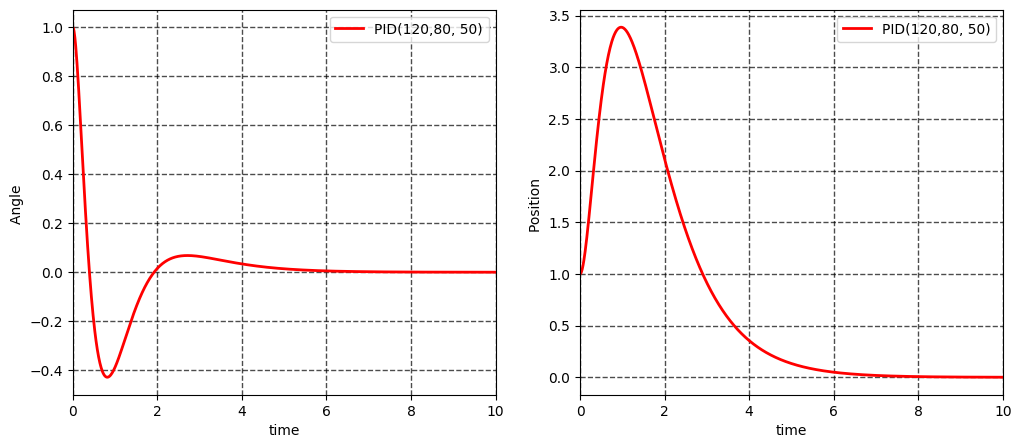

In [14]:
t0 = 0 # Initial time 
tf = 10 # Final time
T = np.linspace(t0, tf, 1000) 

K = ctr.place(A, B, [-1,-2,-3,-4])
x0 = np.array([1,
               0,
               1,
               0])  # initial state

def u_func(x,t):
    return -np.dot(K,x)

def w_func(t):
    # return 10*np.sin(t)
    return 0.0

solution = OpenLoopInputOutputSystem(A, B, D, MatC , u_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[2,:]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[0,:]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

Then we control the system with an LQR regulator (q.2.3)

Text(0, 0.5, 'Position ')

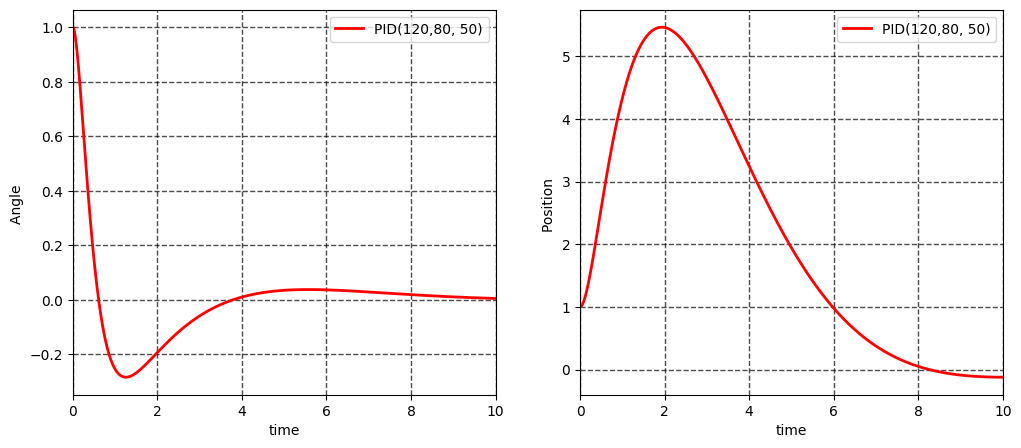

In [16]:
t0 = 0 # Initial time 
tf = 10 # Final time
T = np.linspace(t0, tf, 1000) 

Q = np.eye(4)
R = 1
K,_,_ = ctr.lqr(A, B, Q, R)

x0 = np.array([1,
               0,
               1,
               0])  # initial state

def u_func(x,t):
    return -np.dot(K,x)

def w_func(t):
    return 0.0

solution = OpenLoopInputOutputSystem(A, B, D, MatC , u_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[2,:]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[0,:]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

## DC Motor Speed: System Modeling

A common actuator in control systems is the DC motor. It directly provides rotary motion and, coupled with wheels or drums and cables, can provide translational motion. The electric equivalent circuit of the armature and the free-body diagram of the rotor are shown in the following figure.

For this example, we will assume that the input of the system is the voltage source ($V$) applied to the motor's armature, while the output is the rotational speed of the shaft $\dot{\theta}$. The rotor and shaft are assumed to be rigid. We further assume a viscous friction model, that is, the friction torque is proportional to shaft angular velocity. We will assume that the magnetic field is constant and, therefore, that the motor torque is proportional (with constant $K_t$) to only the armature current. Let us remark that in SI units the motor torque and back emf constants are equal, that is, $K_t = K_e$;

The physical parameters for our example are:

    (J)   moment of inertia of the rotor     0.01 kg.m^2

    (b)     motor viscous friction constant    0.1 N.m.s

    (Ke)    electromotive force constant       0.01 V/rad/sec

    (Kt)    motor torque constant              0.01 N.m/Amp

    (R)     electric resistance                1 Ohm

    (L)     electric inductance                0.5 H
    

Let us suppose that the measured output of the system is the angular velocity of the rotor $\dot{\theta}$ and the current intensity $\dot{i}$. Then the state space model of the system is the following:
$$\dot x = Ax + Bu$$

$$ y = Cx$$

where state vector $x=(\dot{\theta}, i)$, control vector $u=V$, and state and control matrices are the following

$$ A = \begin{pmatrix} -\frac{b}{J}&\frac{K}{J}\\ -\frac{K}{L}&-\frac{R}{L}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{L} 
\end{pmatrix}$$


1. Design a LQR regulator that stabilizes the system in the zero.
2. Design a LQR regulator, that enables tracking a given constant reference for the angular velocity, while assuming that $i_{ref} = 0$. Use integral action to ensure robust tracking. Check the behavior of the closed loop system for $r = 1 rad/c$.

In [ ]:
# System parameters
J = 0.01
b = 0.1
K = 0.01    # Kt = Kl = K
R = 1
L = 0.5

# Matrices 
A = np.array([[-b/J, K/J],
              [-K/L, -R/L]])

B = np.array([[0],
              [1]])

D = np.array([[0],
              [0]])  # Reshaped to column vector

C = np.array([[1, 0],[0,1]])  # Output matrix



############ Calcul du controlleur ############
Q = np.eye(2)
R = 1

K, S, E = ctr.lqr(A, B, Q, R)